In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "payslips.csv"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score


In [5]:
df = pd.read_csv('payslips.csv')

In [6]:
#would add the the line into the pandas df based on knowledge i have
df['Fraud_Heuristic'] = np.where(((df['type'] == 'TRANSFER') &
(df['amount'] > 200000)),1,0)

In [7]:
from sklearn.metrics import f1_score
#f1 score is for accuracy
f1_score(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])
# the best score you can get is 1


0.013131315551742895

In [8]:
print(df.columns)


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'Fraud_Heuristic'],
      dtype='object')


In [9]:
# this confusion matrix creates a visual representation of the accuracy of the heurestic model approach
#from sklearn.metrics import confusion_matrix
#from sklearn import metrics
#cm = metrics.confusion_matrix(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])
#cm2 = metrics.confusion_matrix(['Genuine','Fraud'])


#confusion_matrix = metrics.confusion_matrix(cm, cm2)

#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

#cm_display.plot()
#plt.show()
# how do i do this?


In [10]:
df['hour'] = df['step'] % 24


In [11]:
#From there, we can then count the number of fraudulent and genuine transactions
#at different times. To calculate this, we must run the following code:
frauds = []
genuine = []
for i in range(24):
    f = len(df[(df['hour'] == i) & (df['isFraud'] == 1)])
    g = len(df[(df['hour'] == i) & (df['isFraud'] == 0)])
    frauds.append(f)
    genuine.append(g)

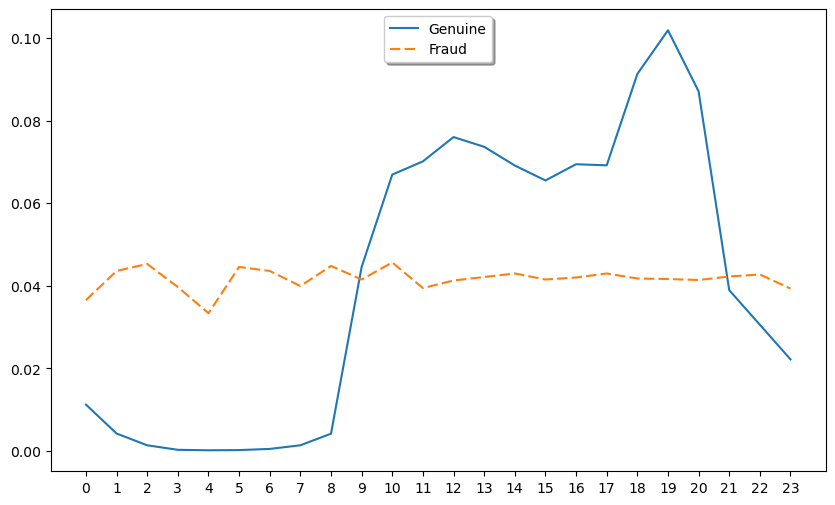

In [12]:
#Then finally, we can plot the share of genuine and fraudulent transactions over the
#course of the day into a chart. To do this, we must run the following code:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(genuine/np.sum(genuine), label='Genuine')
ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)

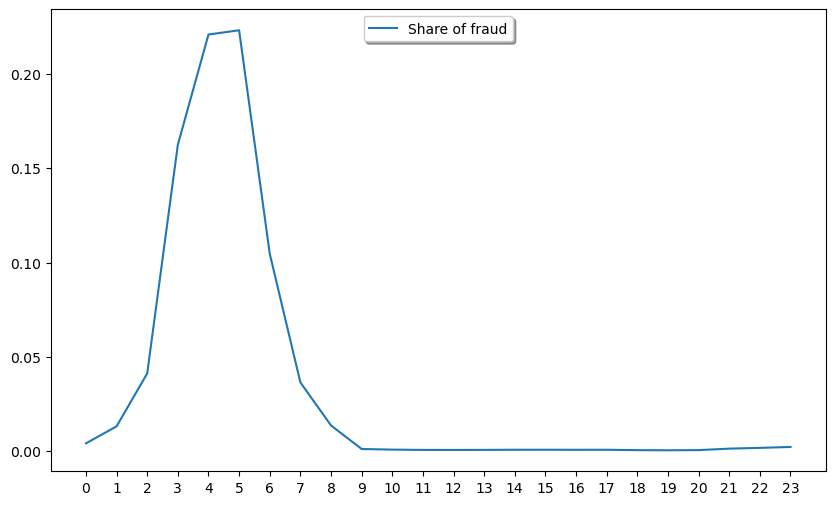

In [13]:
#As we can see in the preceding chart, there are much fewer genuine transactions at
#night, while fraudulent behavior continues over the day. To be sure that night is a
#time when we can hope to catch fraud, we can also plot the number of fraudulent
#transactions as a share of all transactions. To do this, we must run the following
#command:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.divide(frauds,np.add(genuine,frauds)), label='Share of fraud')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)

In [14]:
#We can check whether there are fraudulent transfer destination accounts that are 
#the origin of the fraudulent cash outs by running the following code:
dfFraudTransfer = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashOut = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
dfFraudTransfer.nameDest.isin(dfFraudCashOut.nameOrig).any()

False

In [15]:
#checks how often counts are drained by fraudsters
dfOdd = df[(df.oldbalanceDest == 0) &
    (df.newbalanceDest == 0) &
    (df.amount)]
len(dfOdd[dfOdd['isFraud'] == 1]) / len(dfOdd)
#checks if og account has the funds
#len(dfOdd[(dfOdd.oldBalanceOrig <= dfOdd.amount)]) / len(dfOdd)

0.0017563725684812685

In [16]:
#all entries in this col become strings  and type prefix added
df['type'] = 'Type_' + df['type'].astype(str)

In [17]:
#creates dummmy variables so they can be used in keras
dummies = pd.get_dummies(df['type'])

In [18]:
#get dummies creates a new df so we have to add this new df to the main df
df = pd.concat([df,dummies],axis=1)

In [19]:
#del df['type']

In [20]:
print(df)

         step           type      amount     nameOrig  oldbalanceOrg  \
0           1   Type_PAYMENT     9839.64  C1231006815      170136.00   
1           1   Type_PAYMENT     1864.28  C1666544295       21249.00   
2           1  Type_TRANSFER      181.00  C1305486145         181.00   
3           1  Type_CASH_OUT      181.00   C840083671         181.00   
4           1   Type_PAYMENT    11668.14  C2048537720       41554.00   
...       ...            ...         ...          ...            ...   
6362615   743  Type_CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  Type_TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  Type_CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  Type_TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  Type_CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00  

In [21]:
from keras.layers import Dense, Activation
from keras.models import Sequential

In [22]:
#tokenises the column with the types 
map_dict = {}
for token, value in enumerate(df['type'].unique()):
    map_dict[value] = token


In [23]:
#all types will now be replaced by their tokens.
df["type"].replace(map_dict, inplace=True)

#dealing with other data
other_cols = [c for c in df.columns if ((c != 'type') and (c !='isFraud'))]

In [24]:
#to keep track of our data we need these two arrays
inputs = []
outputs = []

In [27]:
#number of embedding layers is arbitary , reshapes theminto flat arrays
num_types = len(df['type'].unique())
type_embedding_dim = 3
type_in = Input(shape=(1,))
type_embedding = Embedding(num_types,type_embedding_dim,input_length=1)(type_in)
type_out = Reshape(target_shape=(type_embedding_dim,))(type_embedding)
type_model = Model(type_in,type_out)
inputs.append(type_in)
outputs.append(type_out)

NameError: name 'Input' is not defined

In [ ]:
#for the non categorical data
num_rest = len(other_cols)
rest_in = Input(shape = (num_rest,))
rest_out = Dense(16)(rest_in)
rest_model = Model(rest_in,rest_out)
inputs.append(rest_in)
outputs.append(rest_out)

In [ ]:
#concats the two input models
concatenated = Concatenate()(outputs)

In [ ]:
#compiles overall model
x = Dense(16)(concatenated)
x = Activation('sigmoid')(x)
x = Dense(1)(concatenated)
model_out = Activation('sigmoid')(x)
merged_model = Model(inputs, model_out)
merged_model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['accuracy'])

In [ ]:
types = df['type']
rest = df[other_cols]
target = df['isFraud']
#training the model
history = merged_model.fit([types.values,rest.values],target.values,epochs = 1,batch_size = 128)
#extracting the target 
y_df = df['isFraud']
x_df = df.drop('isFraud',axis=1)
y = y_df.values
X = x_df.values

In [ ]:
#test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.33, random_state=42)

In [ ]:
#validation set
X_train, X_test, y_train, y_test = train_test_split(X_train,
y_train, test_size=0.1, random_state=42)

In [ ]:
#Synthetic Minority Over-sampling Technique (SMOTE)
From imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)